# Analisis exploratorio

### Links
- [SentenceTransformers](https://www.sbert.net/)
- [UMAP](https://umap-learn.readthedocs.io/en/latest)
- [Plotting UMAP results](https://umap-learn.readthedocs.io/en/latest/plotting.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from matplotlib import pyplot as plt
import seaborn  as sns

import numpy  as np
import pandas as pd
import torch

import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Chequeamos si se detecta la GPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-08-30 12:35:08,734 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [8]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
set_seed(42)

Parametros de la notebook:

In [10]:
DATASET_PATH = '../datasets'

### Funciones helper

In [11]:
def plot_categories(groups):
    plt.figure(figsize=(15,7))
    ax = sns.barplot(x=groups['category'], y='title', data=groups)
    ax.set(xlabel=None)
    ax.set(xticklabels=[])
    plt.show()

## Preparar dataset

In [12]:
dataset = pd.read_csv(f'{DATASET_PATH}/ebay-all.csv')
dataset.head()

title 
 category 
 category_seq 
 
 
 
 
 0 
 Mrs Sinclair's Suitcase: 'A heart-breaking tal... 
 eBay ~ Books, Comics & Magazines ~ Books 
 0 
 
 
 1 
 Stone Mothers: The addictive new thriller from... 
 eBay ~ Books, Comics & Magazines ~ Books 
 0 
 
 
 2 
 Don't Close Your Eyes: The astonishing psychol... 
 eBay ~ Books, Comics & Magazines ~ Books 
 0 
 
 
 3 
 Regency Scandal: Dissolute Ways: The Runaway C... 
 eBay ~ Books, Comics & Magazines ~ Books 
 0 
 
 
 4 
 Gone Without A Trace: a gripping psychological... 
 eBay ~ Books, Comics & Magazines ~ Books 
 0

# Visualización de categorias de productos

La columna category representa la rama del arbol de categorias donde se encuentra un producto.

In [17]:
category_branches = dataset['category']
category_branches.head()

0    eBay ~ Books, Comics & Magazines ~ Books
1    eBay ~ Books, Comics & Magazines ~ Books
2    eBay ~ Books, Comics & Magazines ~ Books
3    eBay ~ Books, Comics & Magazines ~ Books
4    eBay ~ Books, Comics & Magazines ~ Books
Name: category, dtype: object

Creamos un data frame con todas las arista del arbolde categorias:

In [18]:
def branches_to_data_frame(values, separator='~'):
    data = []
    for i, b in enumerate(values):
        nodes = b.split(separator)
        for idx in range(len(nodes)-1):
            data.append((nodes[idx].strip(), nodes[idx+1].strip()))
    return pd.DataFrame(data, columns=['source', 'target'])

In [19]:
df = branches_to_data_frame(category_branches)

Graficamos la jerarquia de categorias, especificando la cantidad de productos por cada categoria:

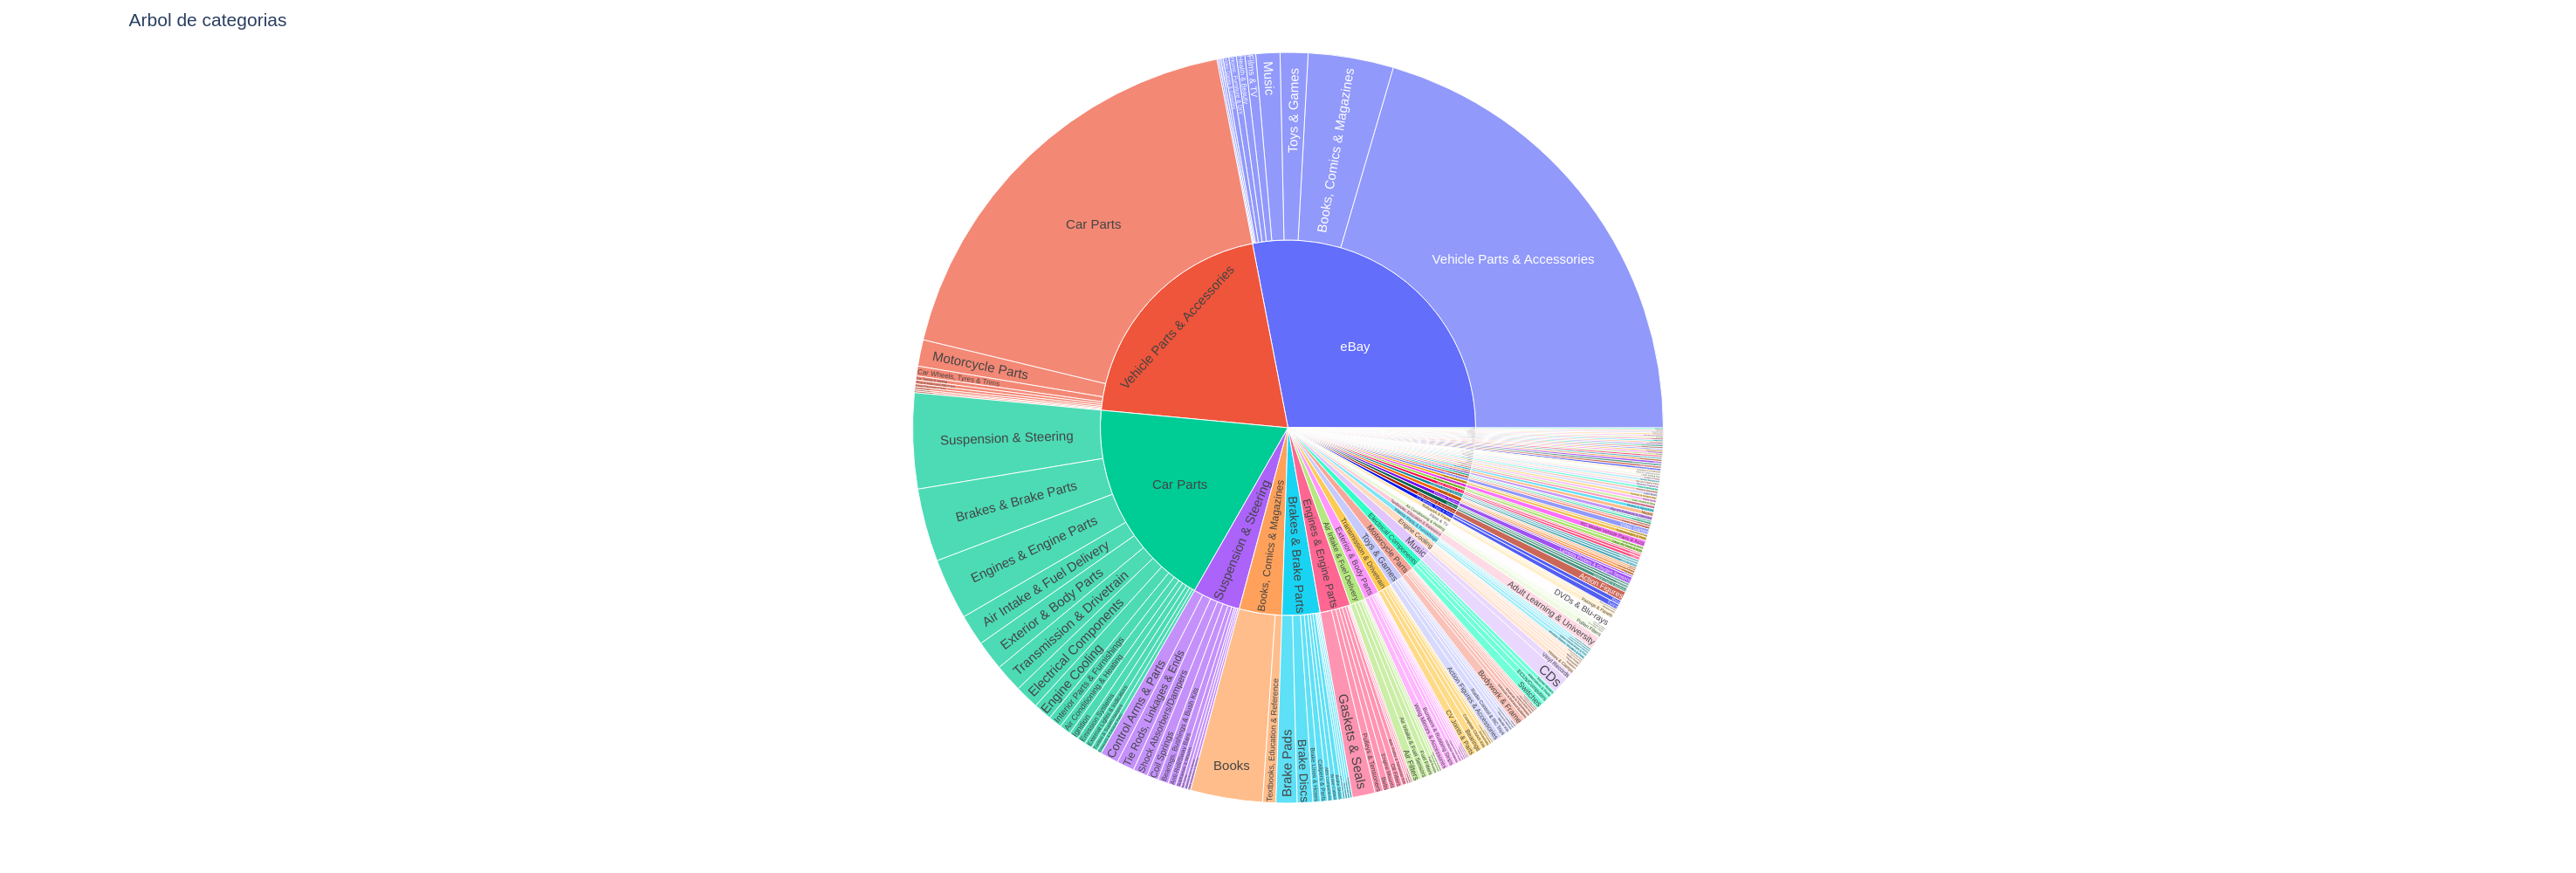

In [20]:
dt.plot_tree(df, title="Arbol de categorias")

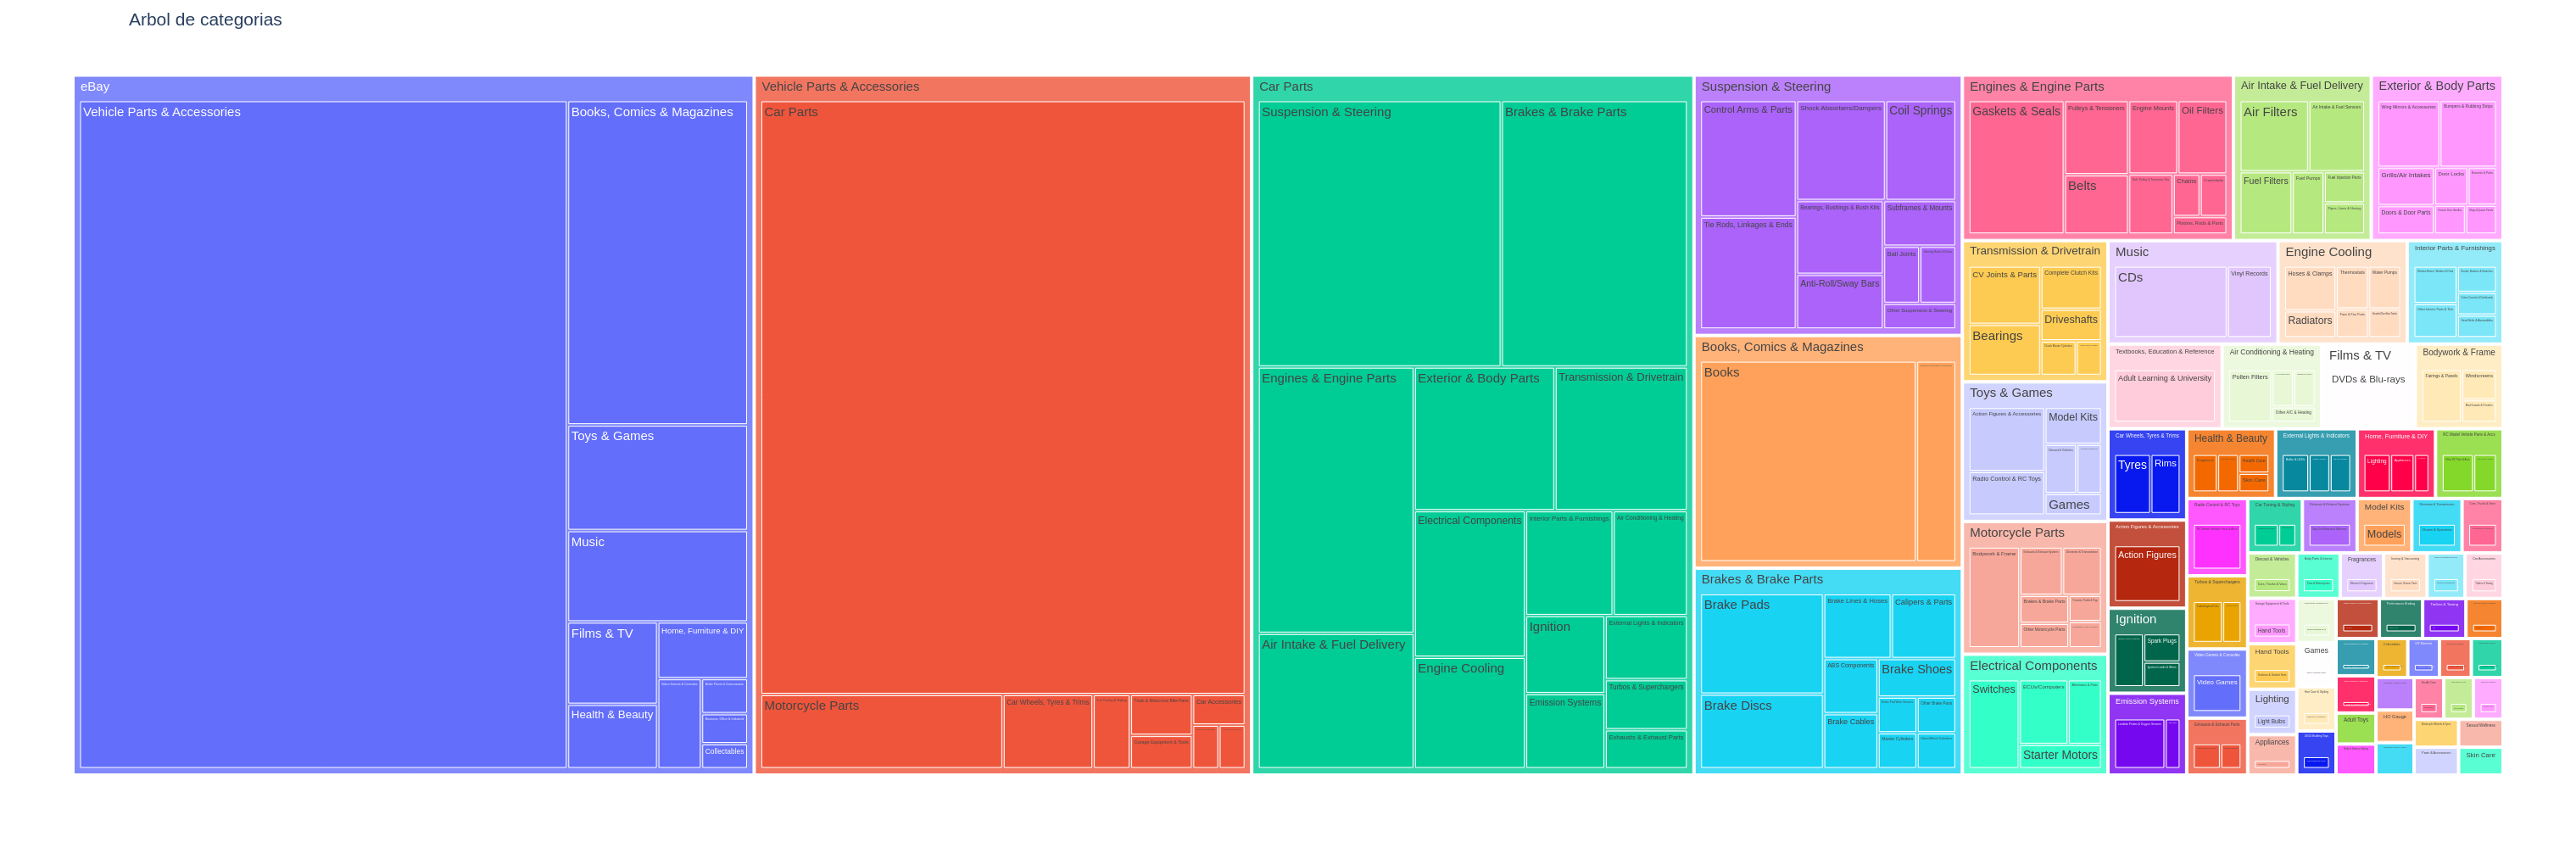

In [21]:
dt.plot_tree(df, title="Arbol de categorias", figure='treemap')

## Cantidad de productos por categoria

<Figure size 1080x504 with 1 Axes>

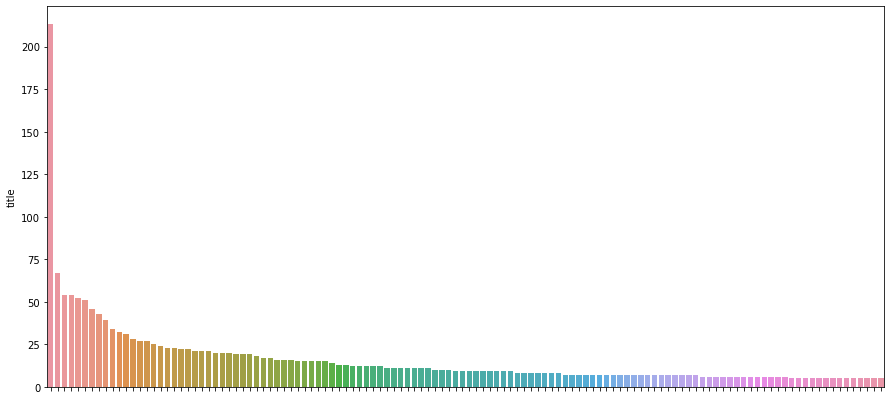

In [22]:
plot_categories(ut.group_by_count(dataset, ['category'], 'title'))

Se aprecio que la variable **category** sigue una ley de potenticas. Es decir, existen pocas categorias que concentra la gran mayoria de productos, y luego muchas categorias que tiene muy pocos productos (Long tail).

## Cluster de categorias

A continacion se generan embeddings para cada categoria y título. Luego, se reduce la dimensionalidad de los embeddings para poder graficar su similitud.

In [26]:
sentence_encoder = ml.SentenceEncoder('all-MiniLM-L6-v2')

2022-08-30 12:42:25,350 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-08-30 12:42:25,671 - INFO - Use pytorch device: cuda


In [73]:
categories = np.unique(dataset['category'])

category_embeddindgs = sentence_encoder(categories)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Opening in existing browser session.


[2430811:2430811:0100/000000.183596:ERROR:vaapi_wrapper.cc(1145)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2430811:2430811:0100/000000.183626:ERROR:vaapi_wrapper.cc(1092)] FillProfileInfo_Locked failed for va_profile VAProfileH264Main and entrypoint VAEntrypointVLD
[2430811:2430811:0100/000000.183638:ERROR:vaapi_wrapper.cc(1145)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2430811:2430811:0100/000000.183645:ERROR:vaapi_wrapper.cc(1092)] FillProfileInfo_Locked failed for va_profile VAProfileH264High and entrypoint VAEntrypointVLD


122

<Figure size 1000x1000 with 1 Axes>

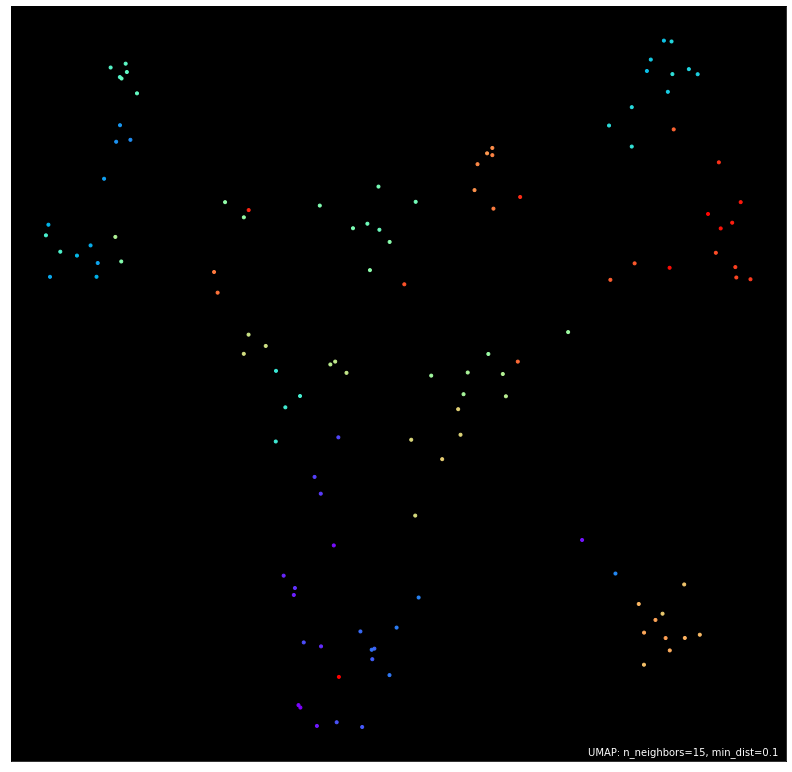

<Figure size 1000x1000 with 1 Axes>

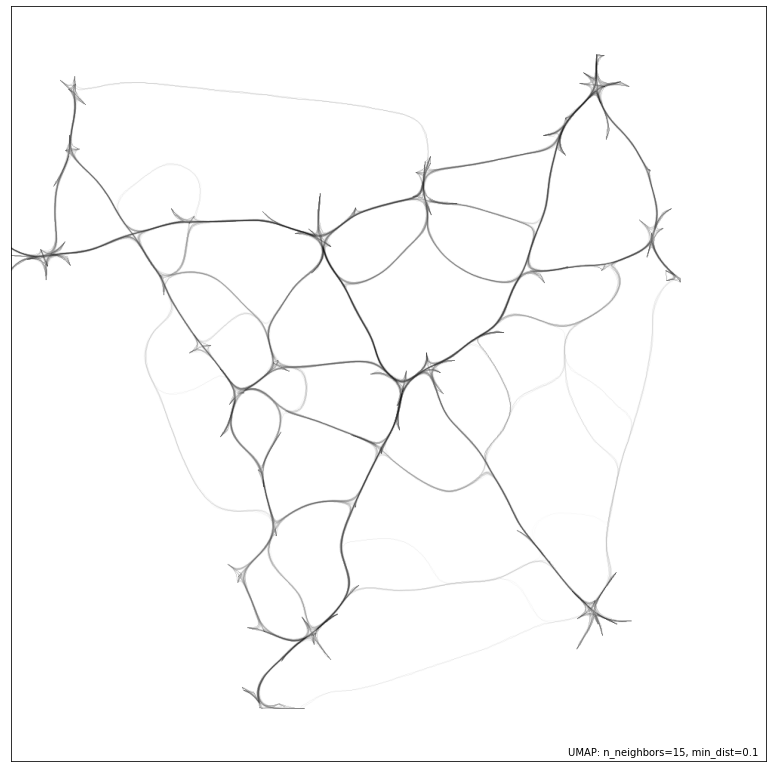

In [74]:
ml.UMAP(category_embeddindgs) \
    .plot_clusters(labels=categories) \
    .plot_interactive_clusters(labels=categories) \
    .plot_connectivity()

len(categories)

## Cluster de productos por similitud entre titulos

A continuación, se generan embeddings para cada título. Luego, se reduce la dimendionalidad para visualizar la distancia entre títulos deacuerdo a su similutud. Los colres representan las categorias a las que pertenece cada título/producto.

In [59]:
title_cat_df = dataset[['title', 'category']].drop_duplicates()

title_cat_df.shape

(1923, 2)

In [60]:
title_embeddindgs  = sentence_encoder(title_cat_df['title'].values)

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Opening in existing browser session.


[2453064:2453064:0100/000000.168796:ERROR:vaapi_wrapper.cc(1145)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2453064:2453064:0100/000000.168826:ERROR:vaapi_wrapper.cc(1092)] FillProfileInfo_Locked failed for va_profile VAProfileH264Main and entrypoint VAEntrypointVLD
[2453064:2453064:0100/000000.168841:ERROR:vaapi_wrapper.cc(1145)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2453064:2453064:0100/000000.168851:ERROR:vaapi_wrapper.cc(1092)] FillProfileInfo_Locked failed for va_profile VAProfileH264High and entrypoint VAEntrypointVLD


<model.umap.UMAP object at 0x7fd168988a90>

<Figure size 1000x1000 with 1 Axes>

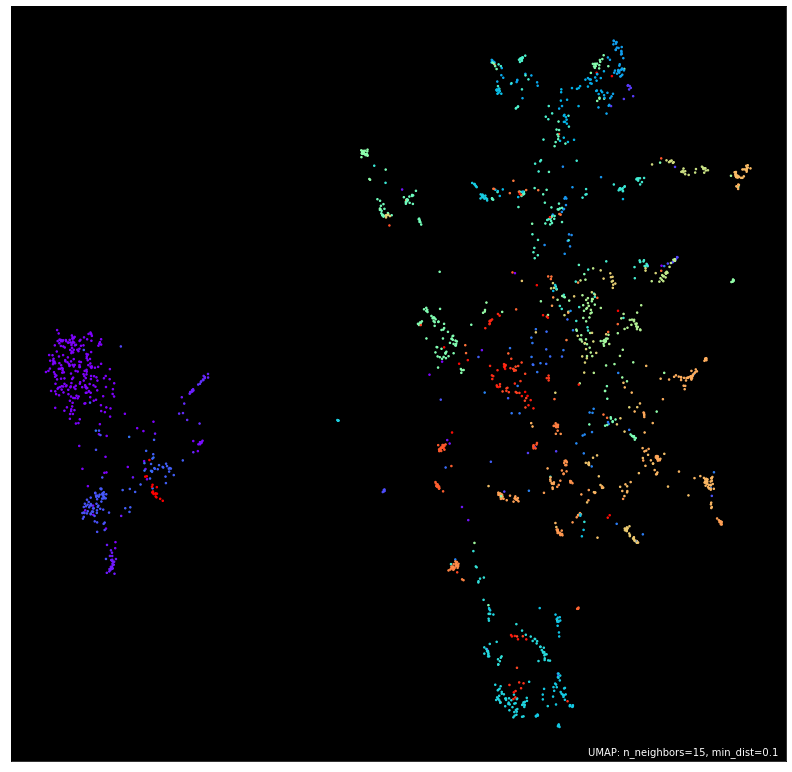

<Figure size 1000x1000 with 1 Axes>

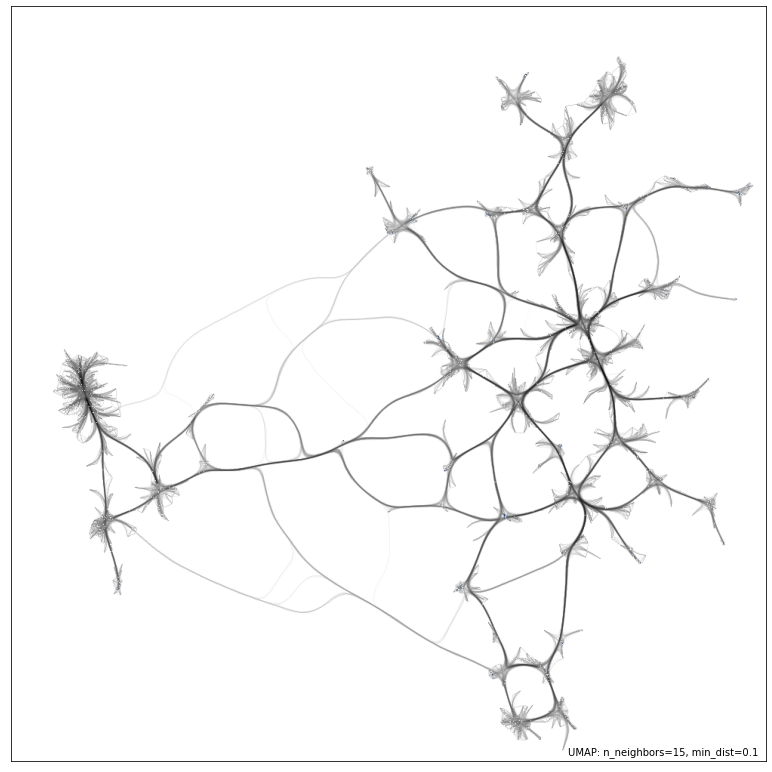

In [75]:
ml.UMAP(title_embeddindgs) \
    .plot_clusters(labels=title_cat_df['category']) \
    .plot_interactive_clusters(labels=title_cat_df['category']) \
    .plot_connectivity()